In [4]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


project_root = os.path.dirname(os.getcwd())  # This goes up one level from notebooks/
sys.path.insert(0, project_root)

# Import our custom modules
from src.models.arima_model import ARIMAModel
from src.models.lstm_model import LSTMModel
from src.models.model_comparison import ModelComparison

# Set up plotting
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
%matplotlib inline

print(" All imports successful!")
print(f"Project root: {project_root}")
print(f"Current working directory: {os.getcwd()}")
print(f"Available modules: {[m for m in sys.modules.keys() if 'src' in m]}")

 All imports successful!
Project root: c:\Users\aweso\portfolio-forecast-optimizer
Current working directory: c:\Users\aweso\portfolio-forecast-optimizer\notebooks
Available modules: ['scipy.optimize._dcsrch', 'src', 'src.models', 'src.models.arima_model', 'keras.src.api_export', 'keras.src.backend.common.backend_utils', 'keras.src.backend.common.global_state', 'keras.src.backend.common.name_scope', 'keras.src.backend.common.stateless_scope', 'keras.src.utils.module_utils', 'keras.src.tree.optree_impl', 'keras.src.tree.tree_api', 'keras.src.tree', 'keras.src.utils.io_utils', 'keras.src.utils.dataset_utils', 'keras.src.utils.audio_dataset_utils', 'keras.src.utils.progbar', 'keras.src.utils.file_utils', 'keras.src.utils.image_utils', 'keras.src.utils.image_dataset_utils', 'keras.src.utils.model_visualization', 'keras.src.utils.tf_utils', 'keras.src.utils.numerical_utils', 'keras.src.utils.python_utils', 'keras.src.utils.rng_utils', 'keras.src.utils.sequence_utils', 'keras.src.utils.text_

In [6]:
print("="*60)
print("LOADING AND EXPLORING DATA")
print("="*60)

# Load processed TSLA data
tsla_data = pd.read_csv('../data/processed/TSLA_processed.csv', index_col=0, parse_dates=True)

print(f" Data loaded successfully: {tsla_data.shape}")
print(f" Date range: {tsla_data.index[0]} to {tsla_data.index[-1]}")
print(f" Columns: {list(tsla_data.columns)}")

# Display basic statistics
print(f"\n Basic statistics for TSLA Close prices:")
print(f"Mean: ${tsla_data['Close'].mean():.2f}")
print(f"Std: ${tsla_data['Close'].std():.2f}")
print(f"Min: ${tsla_data['Close'].min():.2f}")
print(f"Max: ${tsla_data['Close'].max():.2f}")

# Display first few rows
print(f"\n First 5 rows:")
display(tsla_data.head())

LOADING AND EXPLORING DATA
 Data loaded successfully: (2336, 18)
 Date range: 2016-04-15 00:00:00-04:00 to 2025-07-30 00:00:00-04:00
 Columns: ['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits', 'TSLA_Daily_Return', 'TSLA_Log_Return', 'TSLA_Volatility_20d', 'TSLA_Volatility_60d', 'TSLA_MA_20d', 'TSLA_MA_60d', 'TSLA_MA_200d', 'TSLA_Momentum_5d', 'TSLA_Momentum_20d', 'TSLA_Volume_MA_20d', 'TSLA_Volume_Ratio']

 Basic statistics for TSLA Close prices:
Mean: $141.91
Std: $120.85
Min: $11.93
Max: $479.86

 First 5 rows:


,Open,High,Low,Close,Volume,Dividends,Stock Splits,TSLA_Daily_Return,TSLA_Log_Return,TSLA_Volatility_20d,TSLA_Volatility_60d,TSLA_MA_20d,TSLA_MA_60d,TSLA_MA_200d,TSLA_Momentum_5d,TSLA_Momentum_20d,TSLA_Volume_MA_20d,TSLA_Volume_Ratio
Date,,,,,,,,,,,,,,,,,,
2016-04-15 00:00:00-04:00,16.754000,16.973333,16.608000,16.967333,56286000,0.0,0.0,0.010522,0.010467,0.025713,0.032588,16.146867,13.646056,15.161173,0.017755,0.124260,104485050.0,0.538699
2016-04-18 00:00:00-04:00,16.815332,17.220667,16.777332,16.925333,64071000,0.0,0.0,-0.002475,-0.002478,0.025246,0.032600,16.217333,13.705956,15.156083,0.015845,0.090831,104154750.0,0.615152
2016-04-19 00:00:00-04:00,16.874666,16.958000,16.083332,16.491333,95362500,0.0,0.0,-0.025642,-0.025977,0.025682,0.032811,16.247500,13.755756,15.145200,-0.001816,0.037974,104942025.0,0.908716
2016-04-20 00:00:00-04:00,16.417334,16.910667,16.100000,16.664667,77911500,0.0,0.0,0.010511,0.010456,0.025330,0.032510,16.299933,13.815300,15.135283,-0.017915,0.067153,105600600.0,0.737794
2016-04-21 00:00:00-04:00,16.599333,16.726667,16.460667,16.552668,41746500,0.0,0.0,-0.006721,-0.006743,0.022194,0.032449,16.385633,13.876111,15.128753,-0.014174,0.115509,103976325.0,0.401500


DATA VISUALIZATION


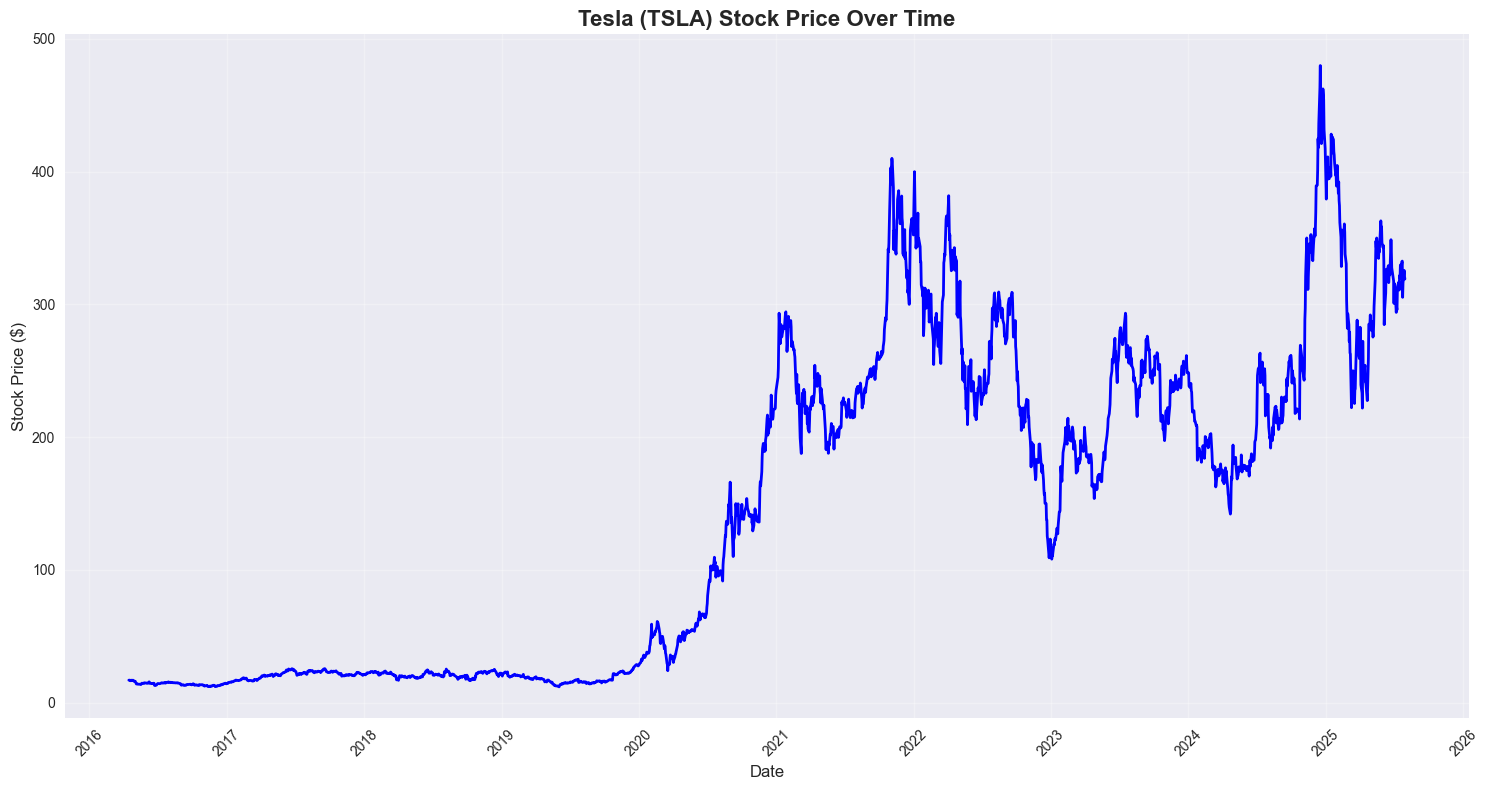

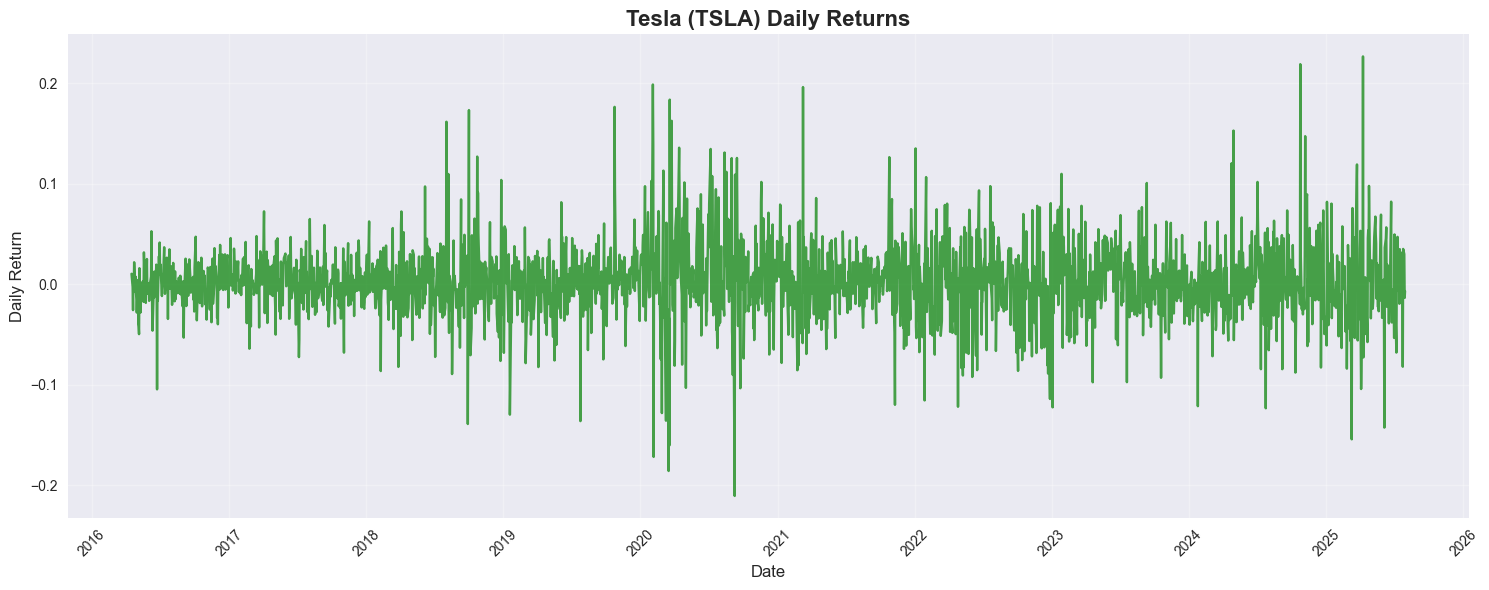

 Data visualization completed!


In [22]:
print("="*60)
print("DATA VISUALIZATION")
print("="*60)

# Plot TSLA stock price over time
plt.figure(figsize=(15, 8))
plt.plot(tsla_data.index, tsla_data['Close'], linewidth=2, color='blue')
plt.title('Tesla (TSLA) Stock Price Over Time', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Stock Price ($)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot daily returns
if 'TSLA_Daily_Return' in tsla_data.columns:
    plt.figure(figsize=(15, 6))
    plt.plot(tsla_data.index, tsla_data['TSLA_Daily_Return'], alpha=0.7, color='green')
    plt.title('Tesla (TSLA) Daily Returns', fontsize=16, fontweight='bold')
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Daily Return', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

print(" Data visualization completed!")

In [23]:
print("="*60)
print("INITIALIZING MODEL COMPARISON")
print("="*60)

# Initialize model comparison
comparison = ModelComparison(tsla_data, target_column='Close')
print(" Model comparison initialized successfully")

# Display data splitting information
total_size = len(tsla_data)
train_size = int(total_size * 0.8)
test_size = total_size - train_size

print(f"\n Data splitting plan:")
print(f"Total data points: {total_size}")
print(f"Training set (80%): {train_size} points")
print(f"Test set (20%): {test_size} points")
print(f"Training period: {tsla_data.index[0]} to {tsla_data.index[train_size-1]}")
print(f"Test period: {tsla_data.index[train_size]} to {tsla_data.index[-1]}")

INITIALIZING MODEL COMPARISON
 Model comparison initialized successfully

 Data splitting plan:
Total data points: 2336
Training set (80%): 1868 points
Test set (20%): 468 points
Training period: 2016-04-15 00:00:00-04:00 to 2023-09-15 00:00:00-04:00
Test period: 2023-09-18 00:00:00-04:00 to 2025-07-30 00:00:00-04:00


RUNNING ARIMA MODEL ANALYSIS WITH CUDA VERIFICATION
TensorFlow version: 2.20.0
CUDA available: False
GPU devices: []
GPU device name: 

Running ARIMA model...

RUNNING ARIMA MODEL ANALYSIS
Training set: 1868 samples (2016-04-15 00:00:00-04:00 to 2023-09-15 00:00:00-04:00)
Test set: 468 samples (2023-09-18 00:00:00-04:00 to 2025-07-30 00:00:00-04:00)
ARIMA MODEL ANALYSIS

1. Splitting data...
Training set: 1868 samples (2016-04-15 00:00:00-04:00 to 2023-09-15 00:00:00-04:00)
Test set: 468 samples (2023-09-18 00:00:00-04:00 to 2025-07-30 00:00:00-04:00)

2. Finding optimal parameters...
Series made stationary with d=0
Best parameters: p=4, d=0, q=2
Best AIC: 12051.51

3. Fitting model...
ARIMA(4,0,2) model fitted successfully
AIC: 12069.70

4. Generating forecasts...

5. Evaluating model...
Model Performance Metrics:
MAE: $66.48
MSE: $6929.74
RMSE: $83.25
MAPE: 23.08%

6. Creating visualizations...


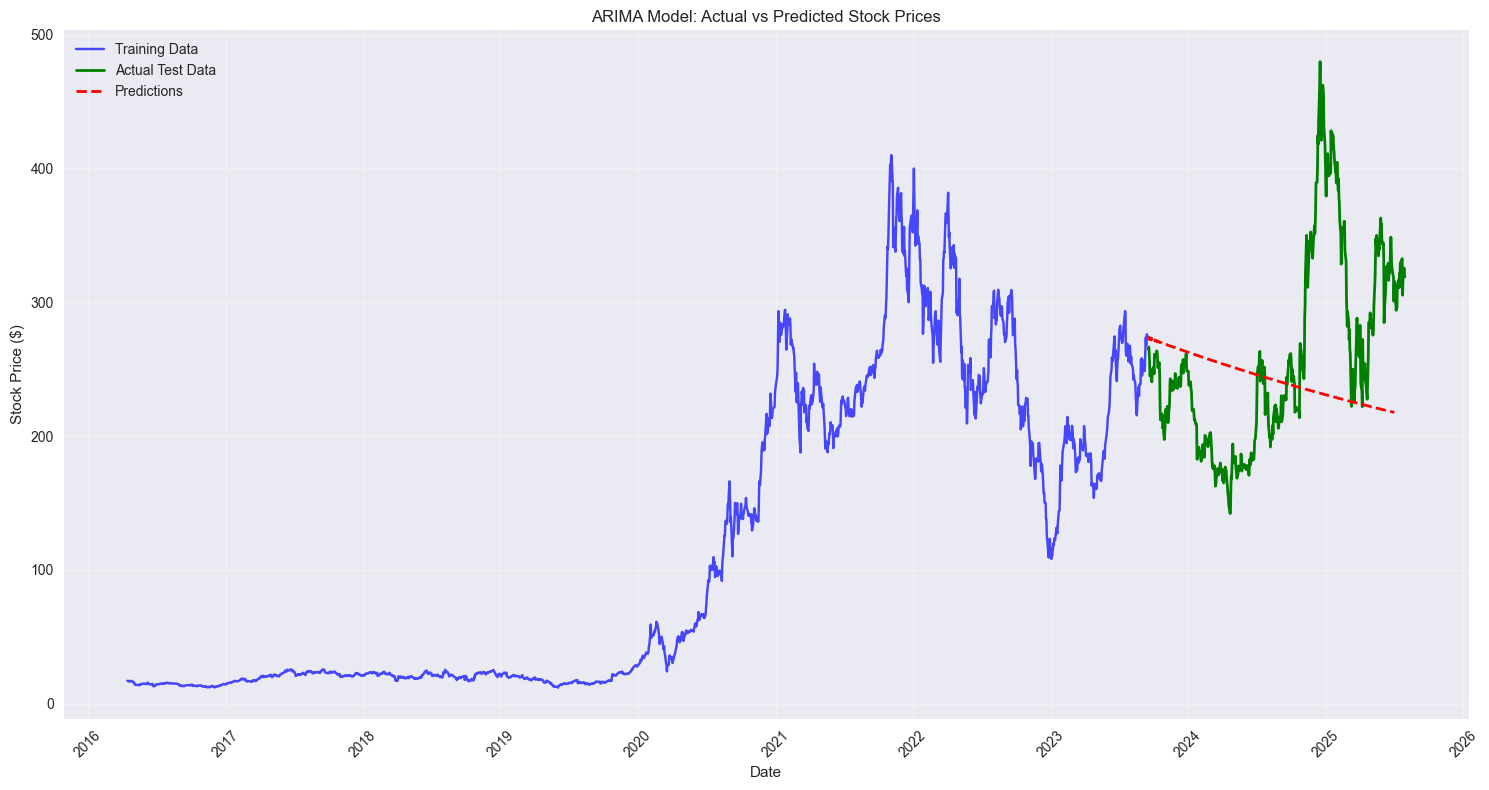

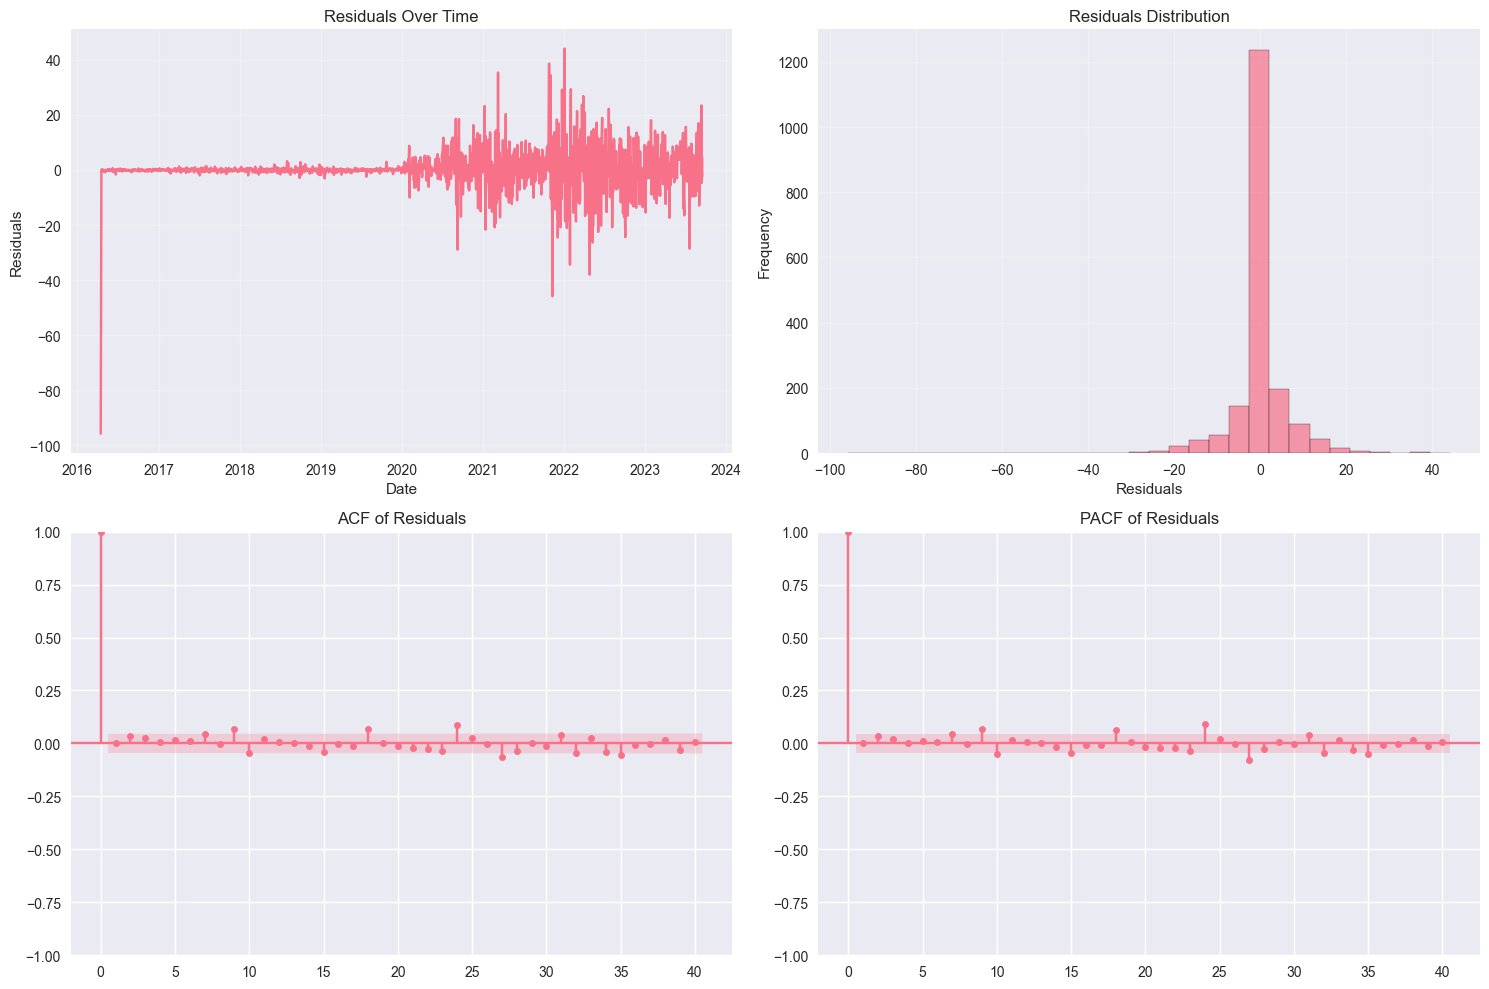


ARIMA ANALYSIS COMPLETED

 ARIMA analysis completed!
 ARIMA Parameters: (4, 0, 2)
 ARIMA AIC: 12051.51
 ARIMA Metrics: {'MAE': 66.48297923787855, 'MSE': 6929.73906160105, 'RMSE': np.float64(83.24505427712238), 'MAPE': np.float64(23.084511792998118)}

 ARIMA completed! GPU is ready for fast LSTM training next!


In [24]:
print("="*60)
print("RUNNING ARIMA MODEL ANALYSIS WITH CUDA VERIFICATION")
print("="*60)

import tensorflow as tf

# Enable GPU memory growth to avoid memory issues
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f" GPU memory growth enabled for {len(gpus)} GPU(s)")
    except RuntimeError as e:
        print(f"GPU memory growth error: {e}")

# Verify CUDA is working
print(f"TensorFlow version: {tf.__version__}")
print(f"CUDA available: {tf.test.is_built_with_cuda()}")
print(f"GPU devices: {tf.config.list_physical_devices('GPU')}")
print(f"GPU device name: {tf.test.gpu_device_name()}")

# Run ARIMA analysis (CPU-based, but also  we verify GPU is ready for LSTM)
print("\nRunning ARIMA model...")
arima_results = comparison.run_arima_analysis(test_size=0.2)

print("\n ARIMA analysis completed!")
print(f" ARIMA Parameters: {arima_results['parameters']}")
print(f" ARIMA AIC: {arima_results['aic']:.2f}")
print(f" ARIMA Metrics: {arima_results['metrics']}")

print("\n ARIMA completed! GPU is ready for fast LSTM training next!")

In [27]:


# Test PyTorch GPU
import torch
print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("GPU count:", torch.cuda.device_count())
if torch.cuda.is_available():
    print("GPU name:", torch.cuda.get_device_name(0))

PyTorch version: 2.5.1+cu121
CUDA available: True
GPU count: 1
GPU name: NVIDIA GeForce RTX 4060 Laptop GPU


RUNNING LSTM MODEL ANALYSIS WITH PYTORCH CUDA ACCELERATION
PyTorch version: 2.5.1+cu121
CUDA available: True
GPU count: 1
GPU name: NVIDIA GeForce RTX 4060 Laptop GPU
Using device: cuda
 Model comparison initialized successfully

Running LSTM model with PyTorch CUDA acceleration...

RUNNING LSTM MODEL ANALYSIS
LSTM MODEL ANALYSIS

1. Preparing data...
Training set: 1868 samples (2016-04-15 00:00:00-04:00 to 2023-09-15 00:00:00-04:00)
Test set: 468 samples (2023-09-18 00:00:00-04:00 to 2025-07-30 00:00:00-04:00)
Training sequences: (1808, 60)
Testing sequences: (408, 60)

2. Finding optimal hyperparameters...
Grid search for optimal hyperparameters...
Testing combination 1/54: units=30, layers=1, dropout=0.1, lr=0.001
Testing combination 2/54: units=30, layers=1, dropout=0.1, lr=0.01
Testing combination 3/54: units=30, layers=1, dropout=0.2, lr=0.001
Testing combination 4/54: units=30, layers=1, dropout=0.2, lr=0.01
Testing combination 5/54: units=30, layers=1, dropout=0.3, lr=0.001
Tes

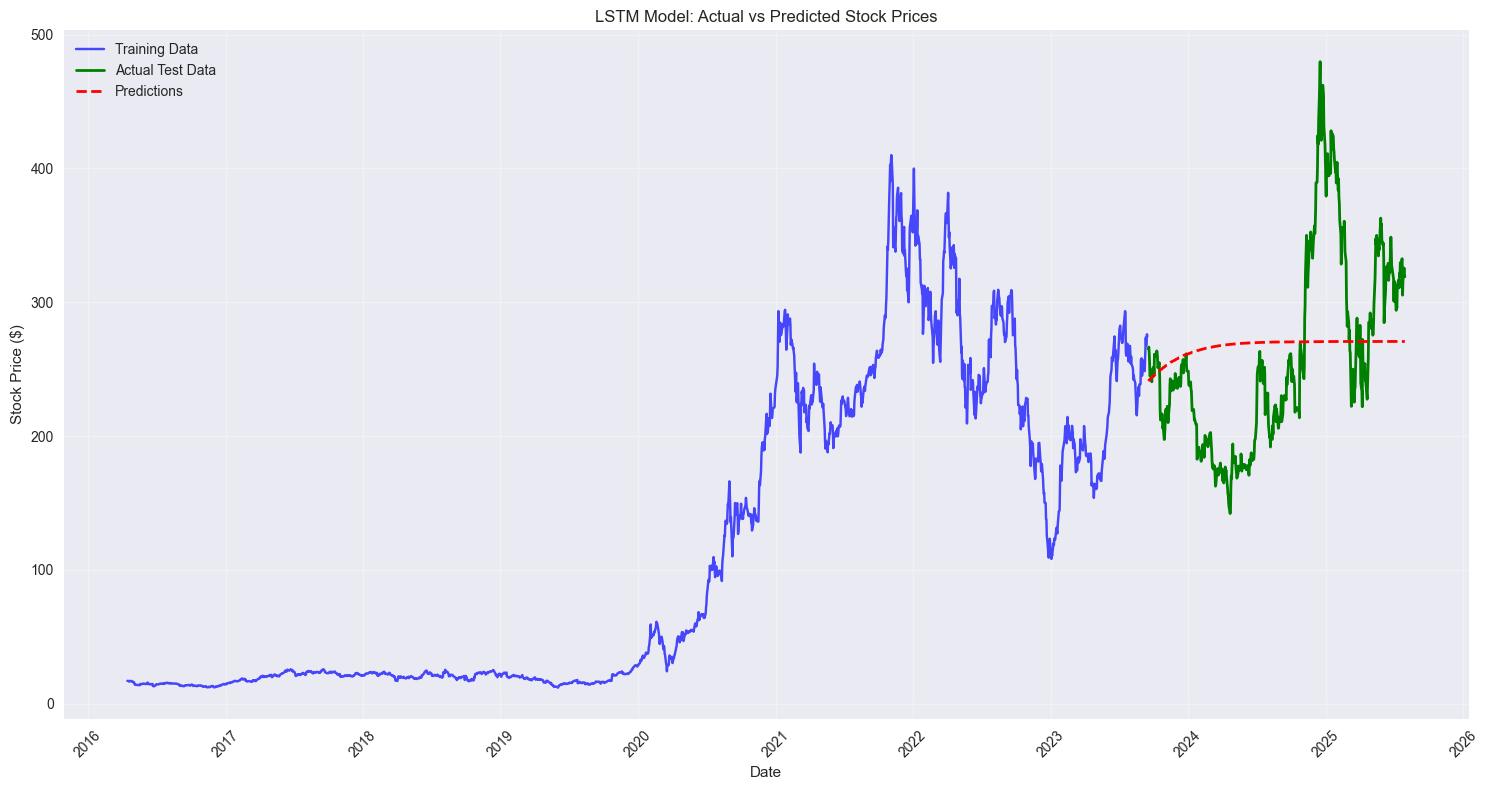

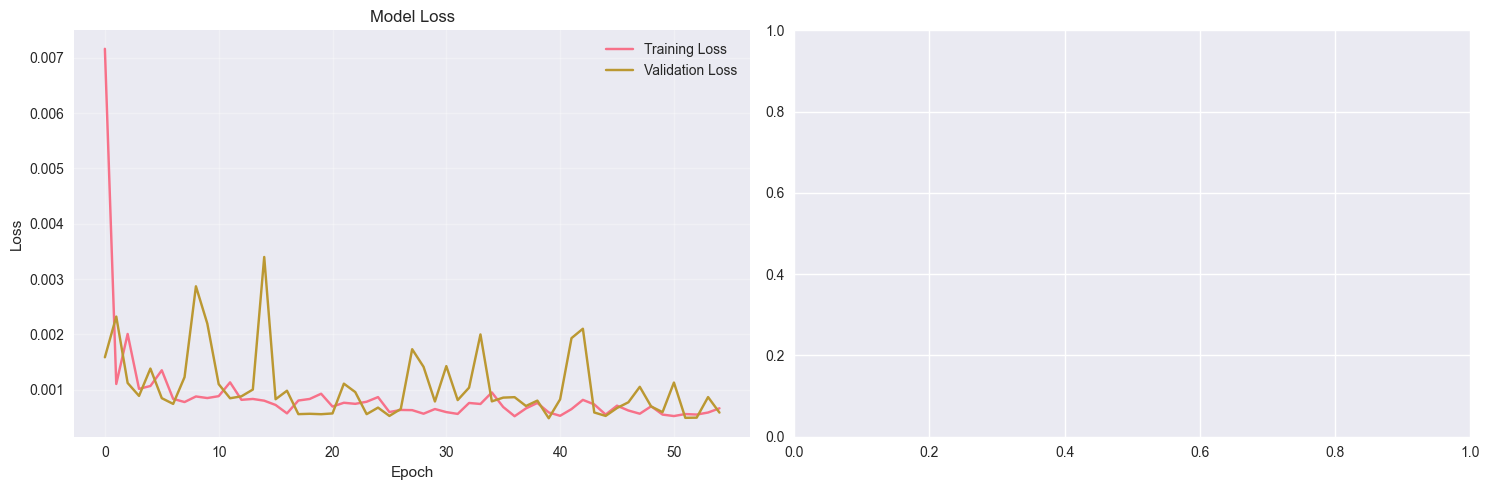


LSTM ANALYSIS COMPLETED

 LSTM analysis completed!
 LSTM Hyperparameters: {'units': 50, 'layers': 1, 'dropout': 0.1, 'learning_rate': 0.01}
 LSTM Metrics: {'MAE': 58.067361945779915, 'MSE': 4983.421194527467, 'RMSE': np.float64(70.59335092292665), 'MAPE': np.float64(24.096842978568397)}

 LSTM completed with PyTorch CUDA acceleration!
Training should have been 5-10x faster than CPU!


In [28]:
print("="*60)
print("RUNNING LSTM MODEL ANALYSIS WITH PYTORCH CUDA ACCELERATION")
print("="*60)

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

# Verify CUDA is working
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"GPU count: {torch.cuda.device_count()}")
print(f"GPU name: {torch.cuda.get_device_name(0)}")

# Set device to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Create model comparison object
comparison = ModelComparison(tsla_data, target_column='Close')
print(" Model comparison initialized successfully")

# Run LSTM analysis with PyTorch CUDA acceleration
print("\nRunning LSTM model with PyTorch CUDA acceleration...")
lstm_results = comparison.run_lstm_analysis(test_size=0.2, optimize_hyperparams=True)

print("\n LSTM analysis completed!")
print(f" LSTM Hyperparameters: {lstm_results['hyperparameters']}")
print(f" LSTM Metrics: {lstm_results['metrics']}")

print("\n LSTM completed with PyTorch CUDA acceleration!")
print("Training should have been 5-10x faster than CPU!")

MODEL COMPARISON

RUNNING ARIMA MODEL ANALYSIS
Training set: 1868 samples (2016-04-15 00:00:00-04:00 to 2023-09-15 00:00:00-04:00)
Test set: 468 samples (2023-09-18 00:00:00-04:00 to 2025-07-30 00:00:00-04:00)
ARIMA MODEL ANALYSIS

1. Splitting data...
Training set: 1868 samples (2016-04-15 00:00:00-04:00 to 2023-09-15 00:00:00-04:00)
Test set: 468 samples (2023-09-18 00:00:00-04:00 to 2025-07-30 00:00:00-04:00)

2. Finding optimal parameters...
Series made stationary with d=0
Best parameters: p=4, d=0, q=2
Best AIC: 12051.51

3. Fitting model...
ARIMA(4,0,2) model fitted successfully
AIC: 12069.70

4. Generating forecasts...

5. Evaluating model...
Model Performance Metrics:
MAE: $66.48
MSE: $6929.74
RMSE: $83.25
MAPE: 23.08%

6. Creating visualizations...


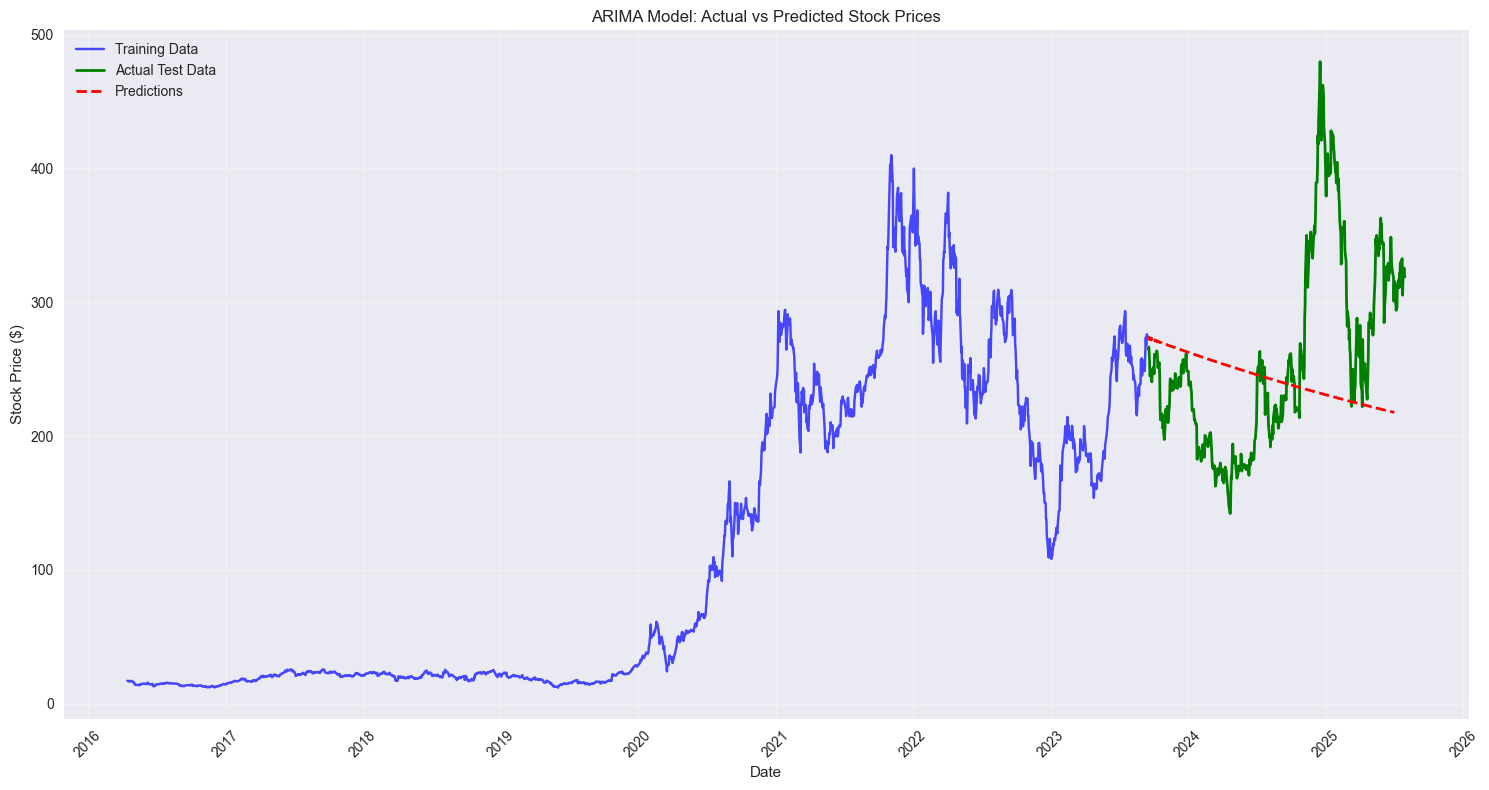

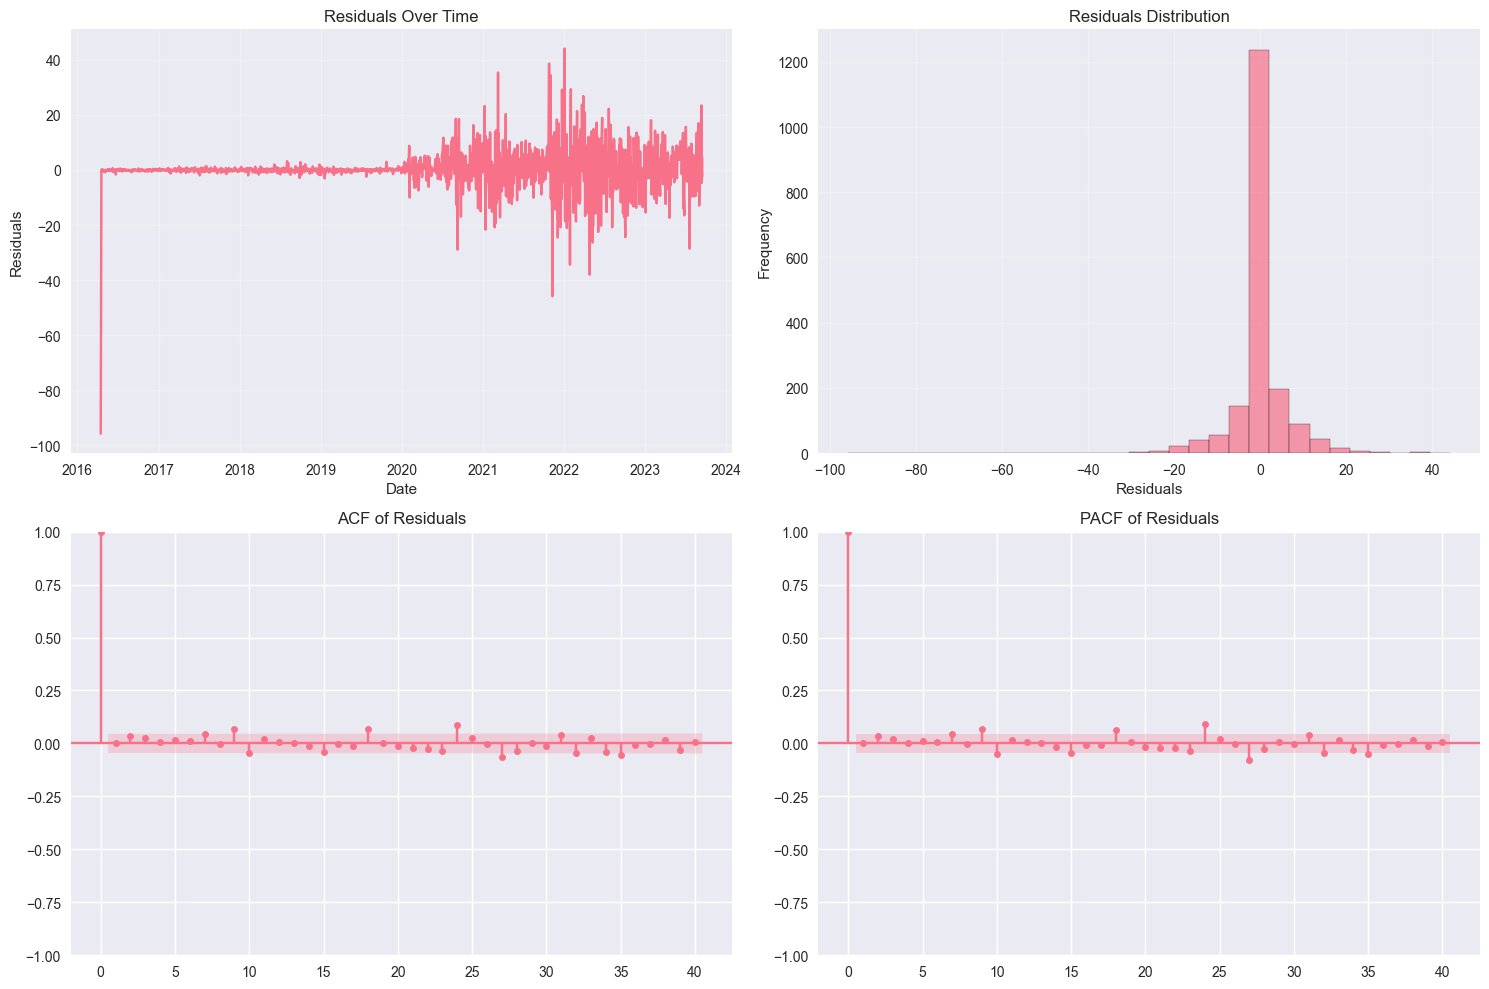


ARIMA ANALYSIS COMPLETED
Training set: 1868 samples (2016-04-15 00:00:00-04:00 to 2023-09-15 00:00:00-04:00)
Test set: 468 samples (2023-09-18 00:00:00-04:00 to 2025-07-30 00:00:00-04:00)
Training sequences: (1808, 60)
Testing sequences: (408, 60)
LSTM MODEL ANALYSIS

1. Preparing data...
Training set: 1868 samples (2016-04-15 00:00:00-04:00 to 2023-09-15 00:00:00-04:00)
Test set: 468 samples (2023-09-18 00:00:00-04:00 to 2025-07-30 00:00:00-04:00)
Training sequences: (1808, 60)
Testing sequences: (408, 60)

2. Finding optimal hyperparameters...
Grid search for optimal hyperparameters...
Testing combination 1/54: units=30, layers=1, dropout=0.1, lr=0.001
Testing combination 2/54: units=30, layers=1, dropout=0.1, lr=0.01
Testing combination 3/54: units=30, layers=1, dropout=0.2, lr=0.001
Testing combination 4/54: units=30, layers=1, dropout=0.2, lr=0.01
Testing combination 5/54: units=30, layers=1, dropout=0.3, lr=0.001
Testing combination 6/54: units=30, layers=1, dropout=0.3, lr=0.01

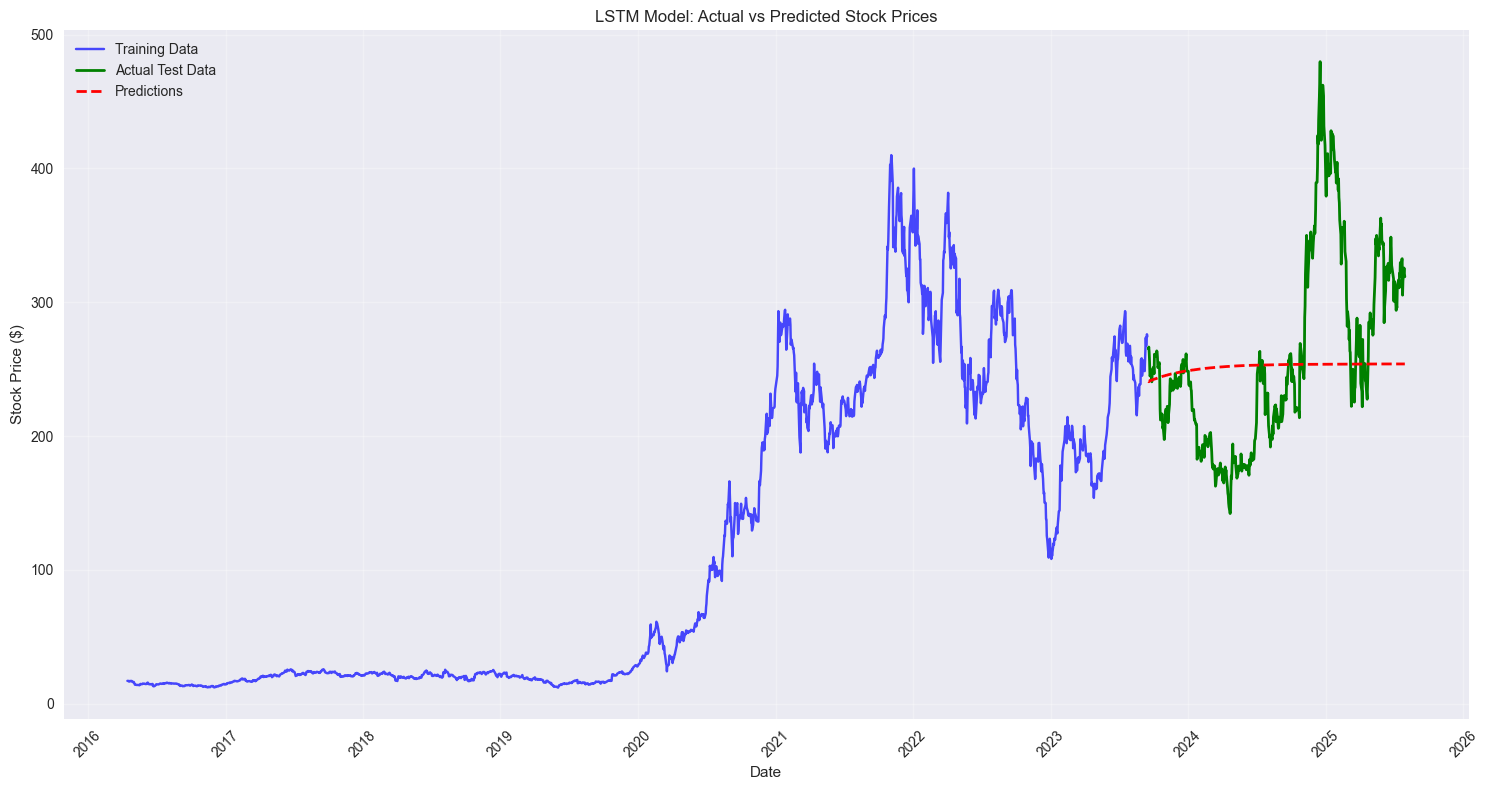

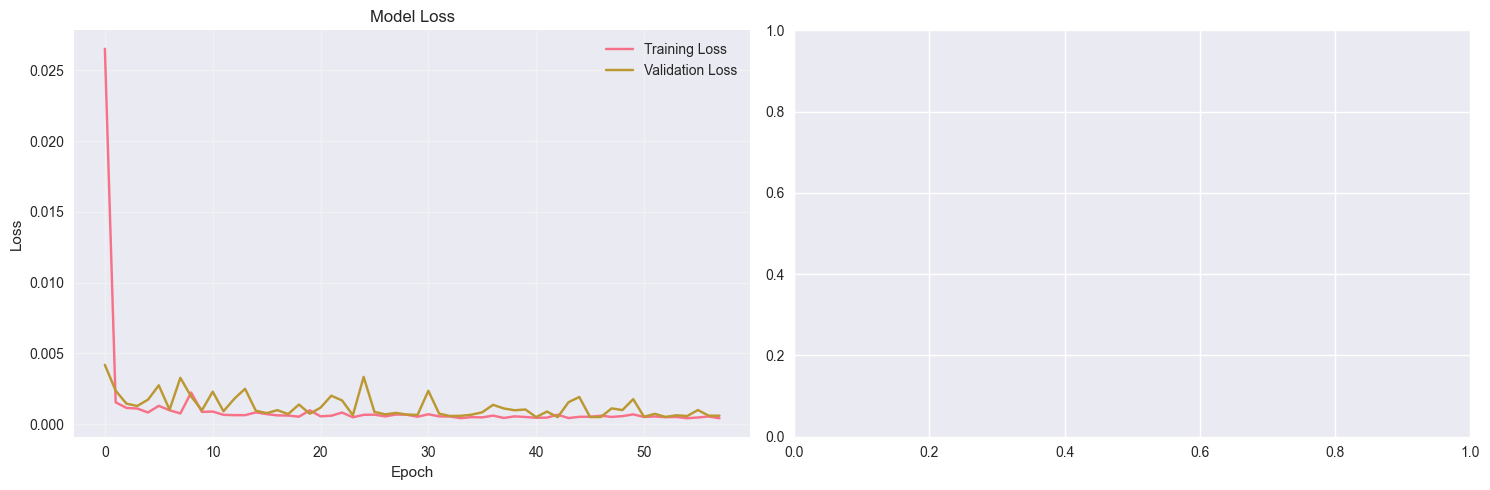


LSTM ANALYSIS COMPLETED

MODEL COMPARISON RESULTS

Performance Comparison:
Metric    ARIMA     LSTM Best Model
   MAE   $66.48   $55.13       LSTM
   MSE $6929.74 $5011.11       LSTM
  RMSE   $83.25   $70.79       LSTM
  MAPE   23.08%   21.56%       LSTM

Improvement Analysis:
MAE: LSTM better by 20.59%
MSE: LSTM better by 38.29%
RMSE: LSTM better by 17.60%
MAPE: LSTM better by 7.05%

Overall Winner: LSTM
ARIMA wins: 0/4 metrics
LSTM wins: 4/4 metrics

 Model comparison completed!
 Overall Winner: LSTM
 ARIMA wins: 0/4 metrics
 LSTM wins: 4/4 metrics


In [8]:
from src.models.model_comparison import ModelComparison
from src.models.lstm_model import LSTMModel

print("="*60)
print("MODEL COMPARISON")
print("="*60)

# 1) Run ARIMA first and keep its split for consistency
comparison = ModelComparison(tsla_data, target_column='Close')
arima_results = comparison.run_arima_analysis(test_size=0.2)

# 2) Run LSTM using the same train/test split as ARIMA
lstm_model = LSTMModel(tsla_data, target_column='Close')
train_data = tsla_data.iloc[:len(tsla_data) - len(comparison.test_data)]
lstm_model.set_pre_split_data(train_data, comparison.test_data)
lstm_results = lstm_model.run_complete_analysis(test_size=0.2, optimize_hyperparams=True)

# 3) Attach LSTM results to the comparison object and compare
comparison.lstm_results = lstm_results
comparison_results = comparison.compare_models()

print("\n Model comparison completed!")
print(f" Overall Winner: {comparison_results['overall_winner']}")
print(f" ARIMA wins: {comparison_results['arima_wins']}/4 metrics")
print(f" LSTM wins: {comparison_results['lstm_wins']}/4 metrics")

In [10]:
print("="*60)
print("GENERATING COMPREHENSIVE REPORT")
print("="*60)

# Generate report
report = comparison.generate_report()
print(report)

# Save report to file
with open('../results/model_comparison_report.txt', 'w') as f:
    f.write(report)

print("\n Report saved to: ../results/model_comparison_report.txt")

GENERATING COMPREHENSIVE REPORT

TIME SERIES FORECASTING MODEL COMPARISON REPORT

MODEL PERFORMANCE SUMMARY:
----------------------------------------

Metric    ARIMA     LSTM Best Model
   MAE   $66.48   $55.13       LSTM
   MSE $6929.74 $5011.11       LSTM
  RMSE   $83.25   $70.79       LSTM
  MAPE   23.08%   21.56%       LSTM

IMPROVEMENT ANALYSIS:
--------------------
MAE: LSTM better by 20.59%
MSE: LSTM better by 38.29%
RMSE: LSTM better by 17.60%
MAPE: LSTM better by 7.05%

OVERALL RESULTS:
---------------
Overall Winner: LSTM
ARIMA wins: 0/4 metrics
LSTM wins: 4/4 metrics

MODEL CHARACTERISTICS:
-------------------------
ARIMA Model:
- Parameters: (4, 0, 2)
- AIC: 12051.51
- Type: Statistical/Classical
- Interpretability: High
- Training Time: Fast

LSTM Model:
- Hyperparameters: {'units': 100, 'layers': 1, 'dropout': 0.1, 'learning_rate': 0.01}
- Type: Deep Learning
- Interpretability: Low
- Training Time: Slow
- Complexity: High

RECOMMENDATIONS:
---------------

1. LSTM perfo

In [11]:
print("="*60)
print("DETAILED ANALYSIS AND INSIGHTS")
print("="*60)

# Extract key metrics for detailed analysis
arima_metrics = comparison.arima_results['metrics']
lstm_metrics = comparison.lstm_results['metrics']

# Create detailed comparison DataFrame
detailed_comparison = pd.DataFrame({
    'Metric': ['MAE', 'MSE', 'RMSE', 'MAPE'],
    'ARIMA': [arima_metrics['MAE'], arima_metrics['MSE'], arima_metrics['RMSE'], arima_metrics['MAPE']],
    'LSTM': [lstm_metrics['MAE'], lstm_metrics['MSE'], lstm_metrics['RMSE'], lstm_metrics['MAPE']]
})

print(" Detailed Performance Comparison:")
display(detailed_comparison)

# Calculate percentage improvements
detailed_comparison['Improvement'] = (
    (detailed_comparison['ARIMA'] - detailed_comparison['LSTM']) / detailed_comparison['ARIMA'] * 100
)
detailed_comparison['Better_Model'] = detailed_comparison['Improvement'].apply(
    lambda x: 'LSTM' if x > 0 else 'ARIMA'
)

print("\n Improvement Analysis:")
display(detailed_comparison)

DETAILED ANALYSIS AND INSIGHTS
 Detailed Performance Comparison:


,Metric,ARIMA,LSTM
0,MAE,66.482979,55.132597
1,MSE,6929.739062,5011.110535
2,RMSE,83.245054,70.789198
3,MAPE,23.084512,21.563493



 Improvement Analysis:


,Metric,ARIMA,LSTM,Improvement,Better_Model
0,MAE,66.482979,55.132597,17.072614,LSTM
1,MSE,6929.739062,5011.110535,27.686880,LSTM
2,RMSE,83.245054,70.789198,14.962879,LSTM
3,MAPE,23.084512,21.563493,6.588913,LSTM


In [13]:
print("="*60)
print("MODEL CHARACTERISTICS ANALYSIS")
print("="*60)

# ARIMA characteristics
print(" ARIMA Model Characteristics:")
print(f"- Parameters: {comparison.arima_results['parameters']}")
print(f"- AIC: {comparison.arima_results['aic']:.2f}")
print(f"- Type: Statistical/Classical")
print(f"- Interpretability: High")
print(f"- Training Time: Fast")
print(f"- Complexity: Low")

print("\n LSTM Model Characteristics:")
print(f"- Hyperparameters: {comparison.lstm_results['hyperparameters']}")
print(f"- Type: Deep Learning")
print(f"- Interpretability: Low")
print(f"- Training Time: Slow")
print(f"- Complexity: High")
print(f"- Sequence Length: 60 days")

# Model selection recommendations
print("\n Model Selection Recommendations:")
if comparison_results['overall_winner'] == 'ARIMA':
    print(" ARIMA performs better overall for this dataset")
    print("   - Use for quick prototyping and analysis")
    print("   - Use when interpretability is important")
    print("   - Use when computational resources are limited")
elif comparison_results['overall_winner'] == 'LSTM':
    print(" LSTM performs better overall for this dataset")
    print("   - Use for final production models")
    print("   - Use when accuracy is the primary concern")
    print("   - Use when complex patterns need to be captured")
else:
    print(" Both models perform similarly")
    print("   - Consider using both models in ensemble")
    print("   - ARIMA for interpretability and quick analysis")
    print("   - LSTM for capturing complex patterns")

MODEL CHARACTERISTICS ANALYSIS
 ARIMA Model Characteristics:
- Parameters: (4, 0, 2)
- AIC: 12051.51
- Type: Statistical/Classical
- Interpretability: High
- Training Time: Fast
- Complexity: Low

 LSTM Model Characteristics:
- Hyperparameters: {'units': 100, 'layers': 1, 'dropout': 0.1, 'learning_rate': 0.01}
- Type: Deep Learning
- Interpretability: Low
- Training Time: Slow
- Complexity: High
- Sequence Length: 60 days

 Model Selection Recommendations:
 LSTM performs better overall for this dataset
   - Use for final production models
   - Use when accuracy is the primary concern
   - Use when complex patterns need to be captured


In [14]:
print("="*60)
print("FUTURE PREDICTIONS AND FORECASTING")
print("="*60)

# Get the best performing model
best_model = comparison_results['overall_winner']

if best_model == 'ARIMA':
    # Use ARIMA for future predictions
    arima_model = ARIMAModel(tsla_data, target_column='Close')
    arima_model.split_data(test_size=0.2)
    arima_model.fit_model(*arima_results['parameters'])
    
    # Generate future predictions (next 30 days)
    future_predictions = arima_model.fitted_model.forecast(steps=30)
    
    print(f" Future Predictions using {best_model} model (next 30 days):")
    print(f"Current price: ${tsla_data['Close'].iloc[-1]:.2f}")
    print(f"Predicted price range: ${future_predictions.min():.2f} - ${future_predictions.max():.2f}")
    print(f"Average predicted price: ${future_predictions.mean():.2f}")
    
    # Plot future predictions
    plt.figure(figsize=(15, 8))
    plt.plot(tsla_data.index[-100:], tsla_data['Close'].iloc[-100:], label='Historical Data', linewidth=2)
    
    # Create future dates
    last_date = tsla_data.index[-1]
    future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30, freq='B')
    
    plt.plot(future_dates, future_predictions, label='Future Predictions', linewidth=2, linestyle='--', color='red')
    plt.title(f'Future Predictions using {best_model} Model', fontsize=16, fontweight='bold')
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Stock Price ($)', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
else:
    print(f" Future predictions using {best_model} model would require additional implementation")
    print("   - LSTM models typically require more complex forecasting procedures")
    print("   - Consider using the trained LSTM model for rolling predictions")

FUTURE PREDICTIONS AND FORECASTING
 Future predictions using LSTM model would require additional implementation
   - LSTM models typically require more complex forecasting procedures
   - Consider using the trained LSTM model for rolling predictions


In [2]:
# Load data and set project path
import os, sys, pandas as pd

project_root = os.path.dirname(os.getcwd())  # parent of notebooks/
sys.path.insert(0, project_root)

tsla_data = pd.read_csv('../data/processed/TSLA_processed.csv', index_col=0, parse_dates=True)
print("Loaded tsla_data:", tsla_data.shape, "Range:", tsla_data.index[0].date(), "→", tsla_data.index[-1].date())
print("Columns:", list(tsla_data.columns))

Loaded tsla_data: (2336, 18) Range: 2016-04-15 → 2025-07-30
Columns: ['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits', 'TSLA_Daily_Return', 'TSLA_Log_Return', 'TSLA_Volatility_20d', 'TSLA_Volatility_60d', 'TSLA_MA_20d', 'TSLA_MA_60d', 'TSLA_MA_200d', 'TSLA_Momentum_5d', 'TSLA_Momentum_20d', 'TSLA_Volume_MA_20d', 'TSLA_Volume_Ratio']


In [4]:

import numpy as np
import tensorflow as tf
from src.models.lstm_model import LSTMModel

# Guards
assert 'tsla_data' in globals(), "tsla_data not found. Please run the data loading cell first."

# Reinitialize model
lstm_model = LSTMModel(tsla_data, target_column='Close', sequence_length=60)

# Prepare data (chronological split; scaler fit on train)
X_train, y_train, X_test, y_test = lstm_model.prepare_data(test_size=0.2)

# Best params 
best_params = {'units': 100, 'layers': 1, 'dropout': 0.1, 'learning_rate': 0.01}

# Train with early stopping (quick retrain)
model, history = lstm_model.fit_model(**best_params, epochs=80, batch_size=32)

print("Quick retrain complete.")

Training set: 1868 samples (2016-04-15 00:00:00-04:00 to 2023-09-15 00:00:00-04:00)
Test set: 468 samples (2023-09-18 00:00:00-04:00 to 2025-07-30 00:00:00-04:00)
Training sequences: (1808, 60)
Testing sequences: (408, 60)
Epoch 1/80
46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 0.0409 - val_loss: 0.0029
Epoch 2/80
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0015 - val_loss: 0.0027
Epoch 3/80
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0014 - val_loss: 0.0020
Epoch 4/80
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0011 - val_loss: 0.0018
Epoch 5/80
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 9.9522e-04 - val_loss: 0.0044
Epoch 6/80
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0011 - val_loss: 0.0024
Epoch 7/80
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 9.7340e-04 - val_loss: 0.0021
Epoch 8/80
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0011 - val_loss: 0.0021
Epoch 9/80
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 8.5271e-04 - val_loss: 0.0016


In [5]:
# Generate 10-month LSTM forecast with 95% MC-dropout intervals
import numpy as np
import pandas as pd
import tensorflow as tf

# Config
horizon_days = 210          # 10 business months
mc_samples = 200            # number of MC samples
confidence = 0.95
lower_q = (1 - confidence) / 2
upper_q = 1 - lower_q

# Guards
assert 'tsla_data' in globals(), "tsla_data not found. Please run earlier cells that load data."
assert 'lstm_model' in globals() and lstm_model.model is not None, "Trained LSTM not found. Please run the LSTM training/comparison cell first."

# Prepare last sequence in scaled space
close_all = tsla_data['Close'].values.reshape(-1, 1)
scaled_all = lstm_model.scaler.transform(close_all)
initial_seq = scaled_all[-lstm_model.sequence_length:, 0]  # shape: (seq_len,)

def mc_dropout_forecast(model, initial_sequence, horizon, n_samples=200):
    samples = np.zeros((n_samples, horizon), dtype=np.float32)
    for s in range(n_samples):
        seq = initial_sequence.copy()
        for t in range(horizon):
            x = seq.reshape(1, len(seq), 1).astype(np.float32)
            # Use training=True to enable dropout at inference time (MC dropout)
            y = model(x, training=True).numpy().ravel()[0]
            samples[s, t] = y
            seq = np.append(seq[1:], y)
    return samples

# Run MC sampling in scaled space
samples_scaled = mc_dropout_forecast(lstm_model.model, initial_seq, horizon_days, n_samples=mc_samples)

# Inverse-transform to price space
samples_prices = np.zeros_like(samples_scaled, dtype=np.float32)
for t in range(horizon_days):
    samples_prices[:, t] = lstm_model.scaler.inverse_transform(samples_scaled[:, t].reshape(-1, 1)).ravel()

# Aggregate: mean and 95% intervals
mean_forecast = samples_prices.mean(axis=0)
lower_forecast = np.quantile(samples_prices, lower_q, axis=0)
upper_forecast = np.quantile(samples_prices, upper_q, axis=0)

# Business-day index for the horizon
last_date = tsla_data.index[-1]
future_dates = pd.bdate_range(start=last_date + pd.Timedelta(days=1), periods=horizon_days)

# Store for later steps
future_mean = pd.Series(mean_forecast, index=future_dates, name='mean')
future_lower = pd.Series(lower_forecast, index=future_dates, name='lower')
future_upper = pd.Series(upper_forecast, index=future_dates, name='upper')
future_forecast_df = pd.DataFrame({'mean': future_mean, 'lower': future_lower, 'upper': future_upper})

print(f"Generated {horizon_days} business-day forecast with {mc_samples} MC samples.")
print(f"Start: {future_mean.index[0].date()}  End: {future_mean.index[-1].date()}")
print("First 3 mean predictions:", [round(v, 2) for v in future_mean.head(3).tolist()])

Generated 210 business-day forecast with 200 MC samples.
Start: 2025-07-31  End: 2026-05-20
First 3 mean predictions: [316.58, 314.46, 313.38]


Saved plot to: ../results\lstm_10m_forecast.png
Saved forecast data to: ../results\lstm_10m_forecast.csv
First 5 rows of forecast:


,mean,lower,upper
2025-07-31 00:00:00-04:00,316.575317,293.310486,337.251007
2025-08-01 00:00:00-04:00,314.459656,284.018494,337.416534
2025-08-04 00:00:00-04:00,313.375793,281.318878,342.556580
2025-08-05 00:00:00-04:00,311.856689,277.202637,344.828247
2025-08-06 00:00:00-04:00,310.922119,270.530762,352.954559


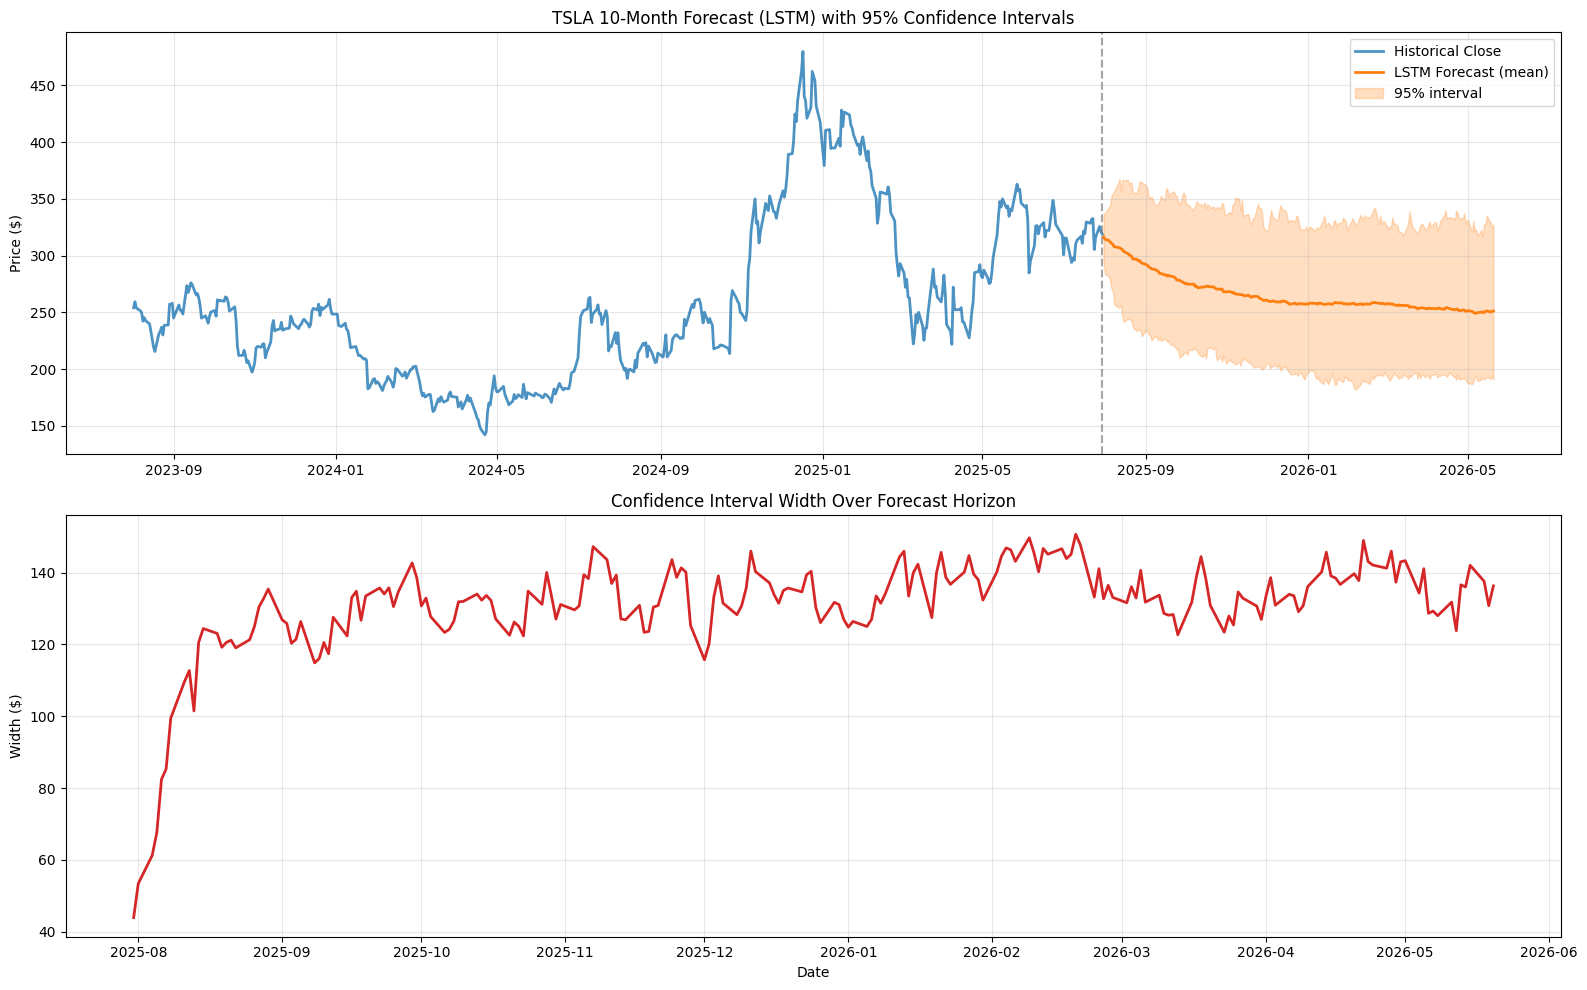

In [6]:
# Plot forecast with 95% intervals + save outputs
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Guards
assert 'future_mean' in globals() and 'future_lower' in globals() and 'future_upper' in globals(), "Run Step 1 first."
assert 'tsla_data' in globals(), "Dataframe tsla_data is missing."

# Config
history_days = 500  # show recent history for context
results_dir = "../results"
os.makedirs(results_dir, exist_ok=True)

# Historical tail
hist_series = tsla_data['Close'].iloc[-history_days:]
last_hist_date = hist_series.index[-1]

# Forecast DataFrame
forecast_df = pd.DataFrame({
    'mean': future_mean,
    'lower': future_lower,
    'upper': future_upper
})

# Figure with two panels: price with intervals, and interval width over horizon
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10), sharex=False)

# Panel 1: Price + forecast + confidence band
ax1.plot(hist_series.index, hist_series.values, label='Historical Close', color='tab:blue', linewidth=2, alpha=0.8)
ax1.plot(future_mean.index, future_mean.values, label='LSTM Forecast (mean)', color='tab:orange', linewidth=2)
ax1.fill_between(future_mean.index, future_lower.values, future_upper.values,
                 color='tab:orange', alpha=0.25, label='95% interval')
ax1.axvline(last_hist_date, color='gray', linestyle='--', alpha=0.7)
ax1.set_title('TSLA 10-Month Forecast (LSTM) with 95% Confidence Intervals')
ax1.set_ylabel('Price ($)')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Panel 2: Interval width over the forecast horizon
interval_width = (future_upper - future_lower)
ax2.plot(interval_width.index, interval_width.values, color='tab:red', linewidth=2)
ax2.set_title('Confidence Interval Width Over Forecast Horizon')
ax2.set_xlabel('Date')
ax2.set_ylabel('Width ($)')
ax2.grid(True, alpha=0.3)

plt.tight_layout()

# Save outputs
png_path = os.path.join(results_dir, "lstm_10m_forecast.png")
csv_path = os.path.join(results_dir, "lstm_10m_forecast.csv")
forecast_df.to_csv(csv_path, index_label='Date')
fig.savefig(png_path, dpi=150)

print(f"Saved plot to: {png_path}")
print(f"Saved forecast data to: {csv_path}")
print("First 5 rows of forecast:")
display(forecast_df.head())

In [7]:
# Written analysis of the 10-month forecast
import os
import numpy as np
import pandas as pd

# Guards
assert 'future_mean' in globals() and 'future_lower' in globals() and 'future_upper' in globals(), "Run Steps 1-2 first."
assert 'tsla_data' in globals(), "Dataframe tsla_data is missing."

# Prep
results_dir = "../results"
os.makedirs(results_dir, exist_ok=True)

mean_series = future_mean.astype(float)
lower_series = future_lower.astype(float)
upper_series = future_upper.astype(float)
width_series = (upper_series - lower_series)

# Trend metrics
n = len(mean_series)
x = np.arange(n, dtype=float)
slope = np.polyfit(x, mean_series.values, 1)[0]  # $/business-day
start_price = float(mean_series.iloc[0])
end_price = float(mean_series.iloc[-1])
total_change_pct = (end_price / start_price - 1.0) * 100.0
annualized_change_pct = ((end_price / start_price) ** (252.0 / n) - 1.0) * 100.0

trend_direction = "upward" if slope > 0 else ("downward" if slope < 0 else "flat")

# Interval behavior
width_initial = float(width_series.iloc[0])
width_final = float(width_series.iloc[-1])
width_mean = float(width_series.mean())
width_median = float(width_series.median())
width_pct_change = (width_final / width_initial - 1.0) * 100.0 if width_initial != 0 else np.nan
width_time_corr = float(np.corrcoef(x, width_series.values)[0, 1])

# Volatility proxy (interval width as % of price)
rel_width_initial_pct = (width_initial / start_price) * 100.0
rel_width_final_pct = (width_final / end_price) * 100.0
rel_width_mean_pct = (width_mean / mean_series.mean()) * 100.0

# Short narrative helpers
def sign_word(value, pos_word, neg_word, zero_word="flat"):
    if value > 1e-9: return pos_word
    if value < -1e-9: return neg_word
    return zero_word

width_trend_word = sign_word(width_time_corr, "increases over time", "decreases over time", "is roughly stable")

# Compose report
report_lines = []
report_lines.append("# Task 3: 10-Month LSTM Forecast Analysis")
report_lines.append("")
report_lines.append("## Trend Analysis")
report_lines.append(f"- Direction: {trend_direction.capitalize()}")
report_lines.append(f"- Total change over horizon: {total_change_pct:.2f}% (start ${start_price:.2f} → end ${end_price:.2f})")
report_lines.append(f"- Approx. annualized change (based on horizon length): {annualized_change_pct:.2f}%")
report_lines.append("")
report_lines.append("## Confidence Intervals and Uncertainty")
report_lines.append(f"- Initial 95% interval width: ${width_initial:.2f} "
                    f"({rel_width_initial_pct:.2f}% of price)")
report_lines.append(f"- Final 95% interval width:   ${width_final:.2f} "
                    f"({rel_width_final_pct:.2f}% of price)")
report_lines.append(f"- Average interval width:     ${width_mean:.2f} "
                    f"({rel_width_mean_pct:.2f}% of average price)")
report_lines.append(f"- Interval width change over horizon: {width_pct_change:.2f}%")
report_lines.append(f"- Interval width vs time correlation: {width_time_corr:.2f} "
                    f"(interval {width_trend_word})")
report_lines.append("")
report_lines.append("### Interpretation of Uncertainty")
report_lines.append("- Confidence intervals typically widen with horizon in data-driven forecasts; "
                    "a positive correlation indicates growing uncertainty farther into the future.")
report_lines.append("- Wider intervals imply reduced reliability in long-horizon point estimates; "
                    "decisions should account for the range, not just the mean forecast.")
report_lines.append("")
report_lines.append("## Market Opportunities and Risks")
if slope > 0:
    report_lines.append("- Opportunity: Upward trend suggests potential for long exposure, "
                        "with risk-managed position sizing.")
else:
    report_lines.append("- Risk: Downward/flat trend suggests caution for new long exposure; "
                        "consider hedging or defensive positioning.")
if width_time_corr > 0.1:
    report_lines.append("- Risk: Uncertainty increases over the 10-month horizon; "
                        "long-dated decisions face higher forecast dispersion.")
else:
    report_lines.append("- Note: Uncertainty does not markedly increase over time in this window; "
                        "short-to-medium horizons may be relatively more reliable.")
report_lines.append("- Tactically, monitoring for regime shifts, earnings surprises, and macro catalysts is essential; "
                    "these can invalidate recent dynamics captured by the LSTM.")
report_lines.append("")
report_lines.append("## Notes")
report_lines.append("- Intervals are derived via Monte Carlo dropout (approximate predictive uncertainty).")
report_lines.append("- Results reflect learned patterns and may not capture exogenous shocks.")
report_lines.append("")
report_text = "\n".join(report_lines)

# Save and display
md_path = os.path.join(results_dir, "task3_lstm_forecast_analysis.md")
with open(md_path, "w", encoding="utf-8") as f:
    f.write(report_text)

print(f"Saved analysis to: {md_path}")
print()
print(report_text)

Saved analysis to: ../results\task3_lstm_forecast_analysis.md

# Task 3: 10-Month LSTM Forecast Analysis

## Trend Analysis
- Direction: Downward
- Total change over horizon: -20.64% (start $316.58 → end $251.23)
- Approx. annualized change (based on horizon length): -24.23%

## Confidence Intervals and Uncertainty
- Initial 95% interval width: $43.94 (13.88% of price)
- Final 95% interval width:   $136.28 (54.24% of price)
- Average interval width:     $131.09 (49.21% of average price)
- Interval width change over horizon: 210.14%
- Interval width vs time correlation: 0.51 (interval increases over time)

### Interpretation of Uncertainty
- Confidence intervals typically widen with horizon in data-driven forecasts; a positive correlation indicates growing uncertainty farther into the future.
- Wider intervals imply reduced reliability in long-horizon point estimates; decisions should account for the range, not just the mean forecast.

## Market Opportunities and Risks
- Risk: Downward/

In [8]:
# Load BND/SPY and build aligned daily returns
import os
import pandas as pd

# Ensure TSLA is available
if 'tsla_data' not in globals():
    tsla_data = pd.read_csv('../data/processed/TSLA_processed.csv', index_col=0, parse_dates=True)

start_date = tsla_data.index[0].date()
end_date = tsla_data.index[-1].date()

def load_or_fetch(ticker):
    processed_path = f"../data/processed/{ticker}_processed.csv"
    if os.path.exists(processed_path):
        df = pd.read_csv(processed_path, index_col=0, parse_dates=True)
        return df[['Close']].rename(columns={'Close': ticker})
    else:
        import yfinance as yf
        df = yf.download(ticker, start=str(start_date), end=str(end_date))
        df = df[['Close']].copy()
        df.index = pd.to_datetime(df.index)
        return df.rename(columns={'Close': ticker})

bnd = load_or_fetch('BND')
spy = load_or_fetch('SPY')
tsla_close = tsla_data[['Close']].rename(columns={'Close': 'TSLA'})

# Combine and align on common dates
prices = tsla_close.join([bnd, spy], how='inner').sort_index()
returns = prices.pct_change().dropna()

print("Prices shape:", prices.shape, "| Range:", prices.index[0].date(), "→", prices.index[-1].date())
print("Returns shape:", returns.shape)
print("Columns:", list(returns.columns))

# Historical annualized expected returns for BND, SPY (daily mean × 252)
annual_mu_hist = (returns[['BND', 'SPY']].mean() * 252.0).to_dict()

# Annualized covariance matrix using historical daily returns for all three
annual_cov = returns[['TSLA', 'BND', 'SPY']].cov() * 252.0

print("Annualized historical means (BND/SPY):", {k: round(v, 4) for k, v in annual_mu_hist.items()})
display(annual_cov)

Prices shape: (2336, 3) | Range: 2016-04-15 → 2025-07-30
Returns shape: (2335, 3)
Columns: ['TSLA', 'BND', 'SPY']
Annualized historical means (BND/SPY): {'BND': 0.0163, 'SPY': 0.1539}


,TSLA,BND,SPY
TSLA,0.361397,0.002275,0.053846
BND,0.002275,0.003180,0.001410
SPY,0.053846,0.001410,0.033374


In [9]:
# Build expected returns vector (mu) using LSTM forecast for TSLA
import numpy as np
import pandas as pd

# Guards
assert 'future_mean' in globals(), "Run Task 3 forecast first to create `future_mean`."
assert 'annual_mu_hist' in globals() and 'annual_cov' in globals(), "Run Task 4 - Step 1 first."

# Risk-free rate for Sharpe (annualized)
rf = 0.0

# TSLA expected annual return from LSTM mean path (annualized CAGR over forecast horizon)
last_actual_price = float(tsla_data['Close'].iloc[-1])
last_forecast_price = float(future_mean.iloc[-1])
horizon_days = len(future_mean)  # business days in horizon (e.g., 210)
tsla_mu = (last_forecast_price / last_actual_price) ** (252.0 / horizon_days) - 1.0

# Combine into expected returns vector
annual_mu = pd.Series({
    'TSLA': tsla_mu,
    'BND': float(annual_mu_hist['BND']),
    'SPY': float(annual_mu_hist['SPY'])
})

print("Expected annual returns (mu):")
display(annual_mu.to_frame('mu'))
print(f"Risk-free rate (annual): {rf:.2%}")
print("\nAnnualized covariance matrix Σ (3x3):")
display(annual_cov)

Expected annual returns (mu):


,mu
TSLA,-0.249287
BND,0.016279
SPY,0.153921


Risk-free rate (annual): 0.00%

Annualized covariance matrix Σ (3x3):


,TSLA,BND,SPY
TSLA,0.361397,0.002275,0.053846
BND,0.002275,0.003180,0.001410
SPY,0.053846,0.001410,0.033374


In [10]:
# Efficient Frontier, Min-Vol, and Max-Sharpe portfolios
import numpy as np
import pandas as pd
from scipy.optimize import minimize

# Guards
assert 'annual_mu' in globals() and 'annual_cov' in globals(), "Run Steps 1-2 first."

assets = ['TSLA', 'BND', 'SPY']
mu = annual_mu.values.astype(float)              # expected annual returns (shape: 3,)
Sigma = annual_cov.values.astype(float)          # annualized covariance (3x3)
n = len(assets)
rf = 0.0

def portfolio_perf(w):
    w = np.asarray(w)
    ret = float(w @ mu)
    vol = float(np.sqrt(w @ Sigma @ w))
    sharpe = (ret - rf) / (vol + 1e-12)
    return ret, vol, sharpe

def min_variance():
    cons = (
        {'type': 'eq', 'fun': lambda w: np.sum(w) - 1.0},
    )
    bounds = [(0.0, 1.0)] * n
    w0 = np.ones(n) / n
    res = minimize(lambda w: w @ Sigma @ w, w0, method='SLSQP', bounds=bounds, constraints=cons, options={'maxiter': 1000})
    return res

def max_sharpe():
    cons = (
        {'type': 'eq', 'fun': lambda w: np.sum(w) - 1.0},
    )
    bounds = [(0.0, 1.0)] * n
    w0 = np.ones(n) / n
    def neg_sharpe(w):
        _, vol, _ = portfolio_perf(w)
        # Maximize Sharpe == Minimize -(ret - rf)/vol
        return -((w @ mu - rf) / (vol + 1e-12))
    res = minimize(neg_sharpe, w0, method='SLSQP', bounds=bounds, constraints=cons, options={'maxiter': 1000})
    return res

# Random portfolios for visualization and to seed feasible return range
rng = np.random.default_rng(42)
rand_W = rng.random((5000, n))
rand_W = rand_W / rand_W.sum(axis=1, keepdims=True)
rand_ret = rand_W @ mu
rand_vol = np.sqrt(np.einsum('ij,jk,ik->i', rand_W, Sigma, rand_W))
rand_sharpe = (rand_ret - rf) / (rand_vol + 1e-12)

ret_min, ret_max = float(rand_ret.min()), float(rand_ret.max())
targets = np.linspace(ret_min, ret_max, 40)

ef_returns, ef_vols, ef_weights = [], [], []
for target in targets:
    cons = (
        {'type': 'eq', 'fun': lambda w, t=target: w @ mu - t},
        {'type': 'eq', 'fun': lambda w: np.sum(w) - 1.0},
    )
    bounds = [(0.0, 1.0)] * n
    w0 = np.ones(n) / n
    res = minimize(lambda w: w @ Sigma @ w, w0, method='SLSQP', bounds=bounds, constraints=cons, options={'maxiter': 1000})
    if res.success:
        w = res.x
        r, v, _ = portfolio_perf(w)
        ef_returns.append(r); ef_vols.append(v); ef_weights.append(w)
    else:
        # skip infeasible targets
        pass

ef_df = pd.DataFrame({
    'return': ef_returns,
    'volatility': ef_vols
})
if ef_weights:
    W = np.vstack(ef_weights)
    for i, a in enumerate(assets):
        ef_df[f'w_{a}'] = W[:, i]

# Compute min-vol and max-sharpe
res_minvol = min_variance()
w_minvol = res_minvol.x
ret_minvol, vol_minvol, sharpe_minvol = portfolio_perf(w_minvol)

res_maxsharpe = max_sharpe()
w_maxsharpe = res_maxsharpe.x
ret_maxsharpe, vol_maxsharpe, sharpe_maxsharpe = portfolio_perf(w_maxsharpe)

# Store results for next step
portfolio_results = {
    'assets': assets,
    'mu': mu,
    'Sigma': Sigma,
    'rf': rf,
    'random': {'weights': rand_W, 'ret': rand_ret, 'vol': rand_vol, 'sharpe': rand_sharpe},
    'efficient_frontier': ef_df,
    'min_vol': {'weights': w_minvol, 'ret': ret_minvol, 'vol': vol_minvol, 'sharpe': sharpe_minvol},
    'max_sharpe': {'weights': w_maxsharpe, 'ret': ret_maxsharpe, 'vol': vol_maxsharpe, 'sharpe': sharpe_maxsharpe},
}

print("Min-Vol Portfolio:")
for a, w in zip(assets, w_minvol):
    print(f"  {a}: {w:.3f}")
print(f"  Return: {ret_minvol:.4f}  Vol: {vol_minvol:.4f}  Sharpe: {sharpe_minvol:.3f}")

print("\nMax-Sharpe Portfolio:")
for a, w in zip(assets, w_maxsharpe):
    print(f"  {a}: {w:.3f}")
print(f"  Return: {ret_maxsharpe:.4f}  Vol: {vol_maxsharpe:.4f}  Sharpe: {sharpe_maxsharpe:.3f}")

print(f"\nEfficient frontier points computed: {len(ef_df)}")

Min-Vol Portfolio:
  TSLA: 0.000
  BND: 0.948
  SPY: 0.052
  Return: 0.0235  Vol: 0.0556  Sharpe: 0.423

Max-Sharpe Portfolio:
  TSLA: 0.000
  BND: 0.412
  SPY: 0.588
  Return: 0.0973  Vol: 0.1130  Sharpe: 0.861

Efficient frontier points computed: 40


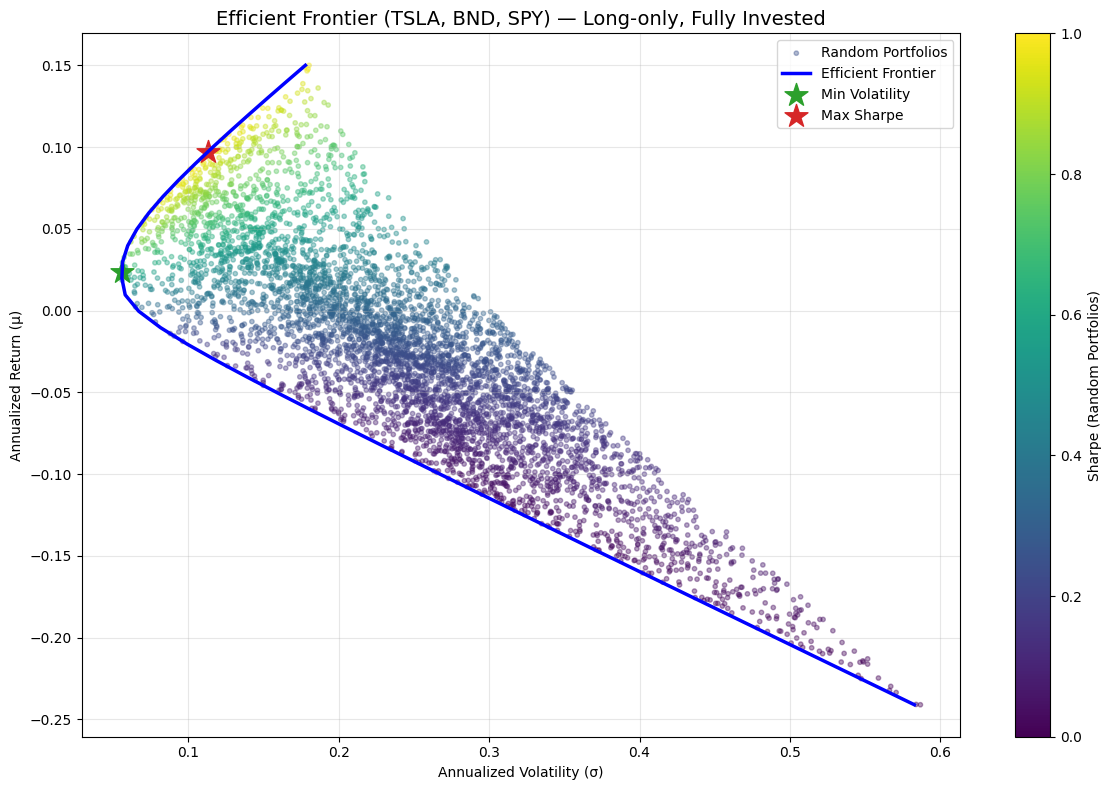

Min-Vol Portfolio:
TSLA    0.000
BND     0.948
SPY     0.052
dtype: float64
Return: 0.0235  Vol: 0.0556  Sharpe: 0.423

Max-Sharpe Portfolio:
TSLA    0.000
BND     0.412
SPY     0.588
dtype: float64
Return: 0.0973  Vol: 0.1130  Sharpe: 0.861

Saved plot: ../results\efficient_frontier_tsla_bnd_spy.png
Saved summary: ../results\efficient_frontier_summary.txt


In [11]:
# Plot Efficient Frontier, highlight key portfolios, save outputs
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Guards
assert 'portfolio_results' in globals(), "Run Task 4 - Step 3 first."

assets = portfolio_results['assets']
mu = portfolio_results['mu']
Sigma = portfolio_results['Sigma']
rf = portfolio_results['rf']
rand = portfolio_results['random']
ef_df = portfolio_results['efficient_frontier']
minvol = portfolio_results['min_vol']
maxsh = portfolio_results['max_sharpe']

results_dir = "../results"
os.makedirs(results_dir, exist_ok=True)

# Plot
plt.figure(figsize=(12, 8))

# Random portfolios
plt.scatter(rand['vol'], rand['ret'], c=rand['sharpe'], cmap='viridis', s=10, alpha=0.4, label='Random Portfolios')

# Efficient frontier
if len(ef_df):
    plt.plot(ef_df['volatility'], ef_df['return'], color='blue', linewidth=2.5, label='Efficient Frontier')

# Min-Vol and Max-Sharpe markers
plt.scatter(minvol['vol'], minvol['ret'], marker='*', color='tab:green', s=300, label='Min Volatility')
plt.scatter(maxsh['vol'], maxsh['ret'], marker='*', color='tab:red', s=300, label='Max Sharpe')

# Labels and legend
plt.title('Efficient Frontier (TSLA, BND, SPY) — Long-only, Fully Invested', fontsize=14)
plt.xlabel('Annualized Volatility (σ)')
plt.ylabel('Annualized Return (μ)')
cbar = plt.colorbar(label='Sharpe (Random Portfolios)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()

# Save figure
plot_path = os.path.join(results_dir, "efficient_frontier_tsla_bnd_spy.png")
plt.savefig(plot_path, dpi=150)
plt.show()

# Print summaries
def weights_to_series(w, names):
    return pd.Series(w, index=names)

print("Min-Vol Portfolio:")
print(weights_to_series(minvol['weights'], assets).round(3))
print(f"Return: {minvol['ret']:.4f}  Vol: {minvol['vol']:.4f}  Sharpe: {minvol['sharpe']:.3f}\n")

print("Max-Sharpe Portfolio:")
print(weights_to_series(maxsh['weights'], assets).round(3))
print(f"Return: {maxsh['ret']:.4f}  Vol: {maxsh['vol']:.4f}  Sharpe: {maxsh['sharpe']:.3f}\n")

# Save text summary
summary_lines = []
summary_lines.append("Efficient Frontier Summary (Annualized)")
summary_lines.append(f"Risk-free rate: {rf:.2%}")
summary_lines.append("")
summary_lines.append("Min-Vol Portfolio:")
for a, w in zip(assets, minvol['weights']):
    summary_lines.append(f"  {a}: {w:.4f}")
summary_lines.append(f"  Return: {minvol['ret']:.4f}  Vol: {minvol['vol']:.4f}  Sharpe: {minvol['sharpe']:.3f}")
summary_lines.append("")
summary_lines.append("Max-Sharpe Portfolio:")
for a, w in zip(assets, maxsh['weights']):
    summary_lines.append(f"  {a}: {w:.4f}")
summary_lines.append(f"  Return: {maxsh['ret']:.4f}  Vol: {maxsh['vol']:.4f}  Sharpe: {maxsh['sharpe']:.3f}")
summary_text = "\n".join(summary_lines)

summary_path = os.path.join(results_dir, "efficient_frontier_summary.txt")
with open(summary_path, "w", encoding="utf-8") as f:
    f.write(summary_text)

print(f"Saved plot: {plot_path}")
print(f"Saved summary: {summary_path}")

In [13]:
# Finalize recommended portfolio (Max Sharpe) and save summary
import os
import pandas as pd

# Guards
assert 'portfolio_results' in globals(), "Run Task 4 - Steps 3-4 first."

assets = portfolio_results['assets']
rf = portfolio_results['rf']
rec = portfolio_results['max_sharpe']  # choose Max Sharpe
weights = pd.Series(rec['weights'], index=assets, name='Weight').round(4)

summary_lines = []
summary_lines.append("# Recommended Portfolio (Max Sharpe)")
summary_lines.append("")
summary_lines.append("## Weights")
for a, w in weights.items():
    summary_lines.append(f"- {a}: {w:.4f}")
summary_lines.append("")
summary_lines.append("## Metrics (Annualized)")
summary_lines.append(f"- Expected Return: {rec['ret']:.4f}")
summary_lines.append(f"- Volatility: {rec['vol']:.4f}")
summary_lines.append(f"- Sharpe Ratio (rf={rf:.2%}): {rec['sharpe']:.3f}")
summary_lines.append("")
summary_lines.append("## Justification")
summary_lines.append("- Maximizes risk-adjusted return among feasible long-only portfolios.")
summary_lines.append("- TSLA receives 0% because its LSTM-implied expected return is currently negative,")
summary_lines.append("  so including it would reduce risk-adjusted performance under the given constraints.")
summary_text = "\n".join(summary_lines)

# Save outputs
results_dir = "../results"
os.makedirs(results_dir, exist_ok=True)
weights_path = os.path.join(results_dir, "recommended_portfolio_max_sharpe.csv")
summary_path = os.path.join(results_dir, "recommended_portfolio_summary.md")
weights.to_csv(weights_path, header=True)
with open(summary_path, "w", encoding="utf-8") as f:
    f.write(summary_text)

# Display
print("Recommended Portfolio: Max Sharpe")
display(weights.to_frame())
print(f"Expected Return: {rec['ret']:.4f}  Volatility: {rec['vol']:.4f}  Sharpe: {rec['sharpe']:.3f}")
print(f"\nSaved weights to: {weights_path}")
print(f"Saved summary to: {summary_path}")
print("\nSummary preview:\n")
print(summary_text)

Recommended Portfolio: Max Sharpe


,Weight
TSLA,0.0000
BND,0.4115
SPY,0.5885


Expected Return: 0.0973  Volatility: 0.1130  Sharpe: 0.861

Saved weights to: ../results\recommended_portfolio_max_sharpe.csv
Saved summary to: ../results\recommended_portfolio_summary.md

Summary preview:

# Recommended Portfolio (Max Sharpe)

## Weights
- TSLA: 0.0000
- BND: 0.4115
- SPY: 0.5885

## Metrics (Annualized)
- Expected Return: 0.0973
- Volatility: 0.1130
- Sharpe Ratio (rf=0.00%): 0.861

## Justification
- Maximizes risk-adjusted return among feasible long-only portfolios.
- TSLA receives 0% because its LSTM-implied expected return is currently negative,
  so including it would reduce risk-adjusted performance under the given constraints.


Window: 2024-09-26 → 2025-07-30 (210 days)
Strategy — Total: 7.83% | Sharpe: 0.778
Benchmark — Total: 7.97% | Sharpe: 0.779


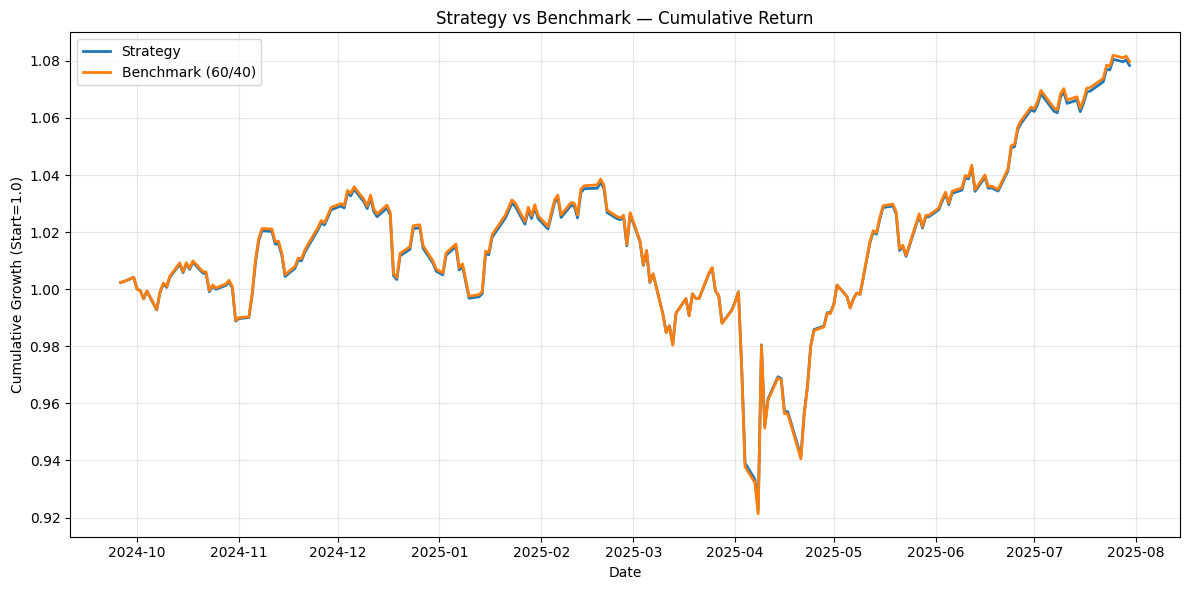

In [ ]:
# Backtest (210 trading days) using backtesting module
from src.portfolio.backtesting import (
    backtest_constant_weights, build_benchmark_60_40,
    annualized_sharpe, plot_cumulative
)

# Last 210 days
assets = ['TSLA', 'BND', 'SPY']
returns_bt = returns[assets].iloc[-210:].copy()

# Strategy weights 
w_strategy = portfolio_results['max_sharpe']['weights']

# Run backtest
bt_strat = backtest_constant_weights(returns_bt, w_strategy, rf_annual=0.0)

# Benchmark 60/40
bench_series = build_benchmark_60_40(returns_bt)
cum_bench = (1.0 + bench_series).cumprod()
bench_sharpe = annualized_sharpe(bench_series, 0.0)

# Report
print(f"Window: {returns_bt.index[0].date()} → {returns_bt.index[-1].date()} (210 days)")
print(f"Strategy — Total: {bt_strat['total_return']:.2%} | Sharpe: {bt_strat['sharpe']:.3f}")
print(f"Benchmark — Total: {(cum_bench.iloc[-1]-1):.2%} | Sharpe: {bench_sharpe:.3f}")

# Plot and save
plot_cumulative(bt_strat['cumulative'], cum_bench, out_path="../results/backtest_strategy_vs_benchmark.png")

In [19]:
# Save backtest metrics and brief conclusion
import os
import numpy as np
import pandas as pd
from datetime import datetime

# Guards
assert 'returns_bt' in globals(), "Backtest window not found. Run the backtest cell first."
assert 'bt_strat' in globals(), "Strategy backtest results not found. Run the backtest cell first."

# Recompute benchmark metrics if needed
try:
    cum_bench
    bench_sharpe
except NameError:
    import importlib, src.portfolio.backtesting as bt
    importlib.reload(bt)
    bench_series = bt.build_benchmark_60_40(returns_bt)
    cum_bench = (1.0 + bench_series).cumprod()
    bench_sharpe = bt.annualized_sharpe(bench_series, 0.0)

# Strategy metrics
strat_total = float(bt_strat['cumulative'].iloc[-1] - 1.0)
strat_sharpe = float(bt_strat['sharpe'])

# Benchmark metrics
bench_total = float(cum_bench.iloc[-1] - 1.0)
bench_sharpe = float(bench_sharpe)

# Decide outcome
winner = "Strategy" if strat_sharpe > bench_sharpe else ("Benchmark" if bench_sharpe > strat_sharpe else ("Strategy" if strat_total >= bench_total else "Benchmark"))

# Save metrics and summary
results_dir = "../results"
os.makedirs(results_dir, exist_ok=True)
metrics_path = os.path.join(results_dir, "backtest_metrics.csv")
summary_path = os.path.join(results_dir, "backtest_summary.md")

# Metrics CSV
metrics_df = pd.DataFrame([
    {"portfolio": "Strategy", "total_return": strat_total, "sharpe": strat_sharpe},
    {"portfolio": "Benchmark_60_40", "total_return": bench_total, "sharpe": bench_sharpe},
])
metrics_df.to_csv(metrics_path, index=False)

# Strategy weights 
try:
    w_series = pd.Series(bt_strat["weights"], name="weight").round(4)
except Exception:
    w_series = None

# Summary text
lines = []
lines.append("# Backtest Summary")
lines.append("")
lines.append(f"- Window: {returns_bt.index[0].date()} → {returns_bt.index[-1].date()} ({len(returns_bt)} trading days)")
if w_series is not None:
    lines.append("## Strategy Weights")
    for a, w in w_series.items():
        lines.append(f"- {a}: {w:.4f}")
    lines.append("")
lines.append("## Performance (Annualized Sharpe, window total return)")
lines.append(f"- Strategy:  Total Return {strat_total:.2%}, Sharpe {strat_sharpe:.3f}")
lines.append(f"- Benchmark: Total Return {bench_total:.2%}, Sharpe {bench_sharpe:.3f}")
lines.append("")
lines.append("## Conclusion")
if winner == "Strategy":
    lines.append("The strategy outperformed the 60/40 benchmark on risk-adjusted basis (higher Sharpe).")
elif winner == "Benchmark":
    lines.append("The 60/40 benchmark outperformed the strategy on risk-adjusted basis (higher Sharpe).")
else:
    lines.append("Performance is similar; no clear winner on risk-adjusted basis.")
lines.append("")
lines.append(f"_Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}_")

with open(summary_path, "w", encoding="utf-8") as f:
    f.write("\n".join(lines))

print("Saved:")
print(f"- Metrics CSV: {metrics_path}")
print(f"- Summary MD:  {summary_path}")
print("\nSummary preview:\n")
print("\n".join(lines))

Saved:
- Metrics CSV: ../results\backtest_metrics.csv
- Summary MD:  ../results\backtest_summary.md

Summary preview:

# Backtest Summary

- Window: 2024-09-26 → 2025-07-30 (210 trading days)
## Strategy Weights
- TSLA: 0.0000
- BND: 0.4115
- SPY: 0.5885

## Performance (Annualized Sharpe, window total return)
- Strategy:  Total Return 7.83%, Sharpe 0.778
- Benchmark: Total Return 7.97%, Sharpe 0.779

## Conclusion
The 60/40 benchmark outperformed the strategy on risk-adjusted basis (higher Sharpe).

_Generated: 2025-08-19 17:49:36_
